In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.plotsiii import plotiii1, plotiii2


In [ ]:
# set seed
np.random.seed(120420)

: 

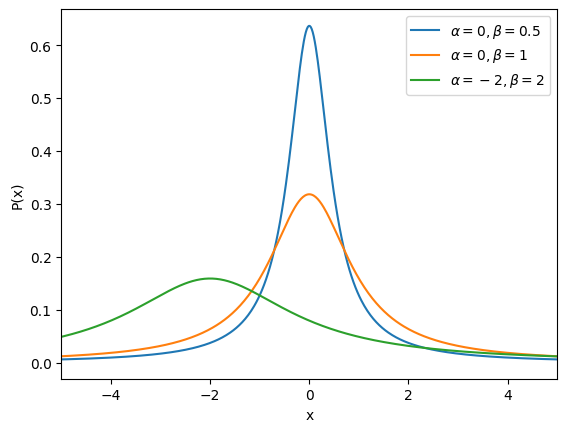

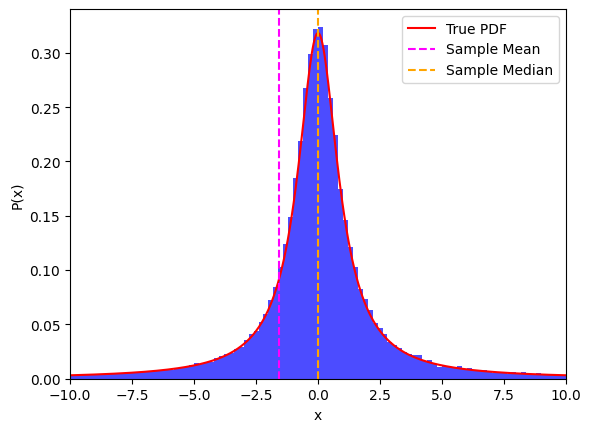

In [2]:
plotiii1()
plotiii2()


### Tensorflow HMC 

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
